<center><h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Sentiment Analysis using BERT </h1></center>

In [ ]:
import re 
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import string
import emoji
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, logging
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import warnings
warnings.filterwarnings('ignore')
logging.set_verbosity_error()

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
csv_path = "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"
df =  pd.read_csv(csv_path, encoding="ISO-8859-1", header=None , names=['label', 'ids', 'data', 'flag' , 'user','sentence'])

print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 1,600,000



,label,ids,data,flag,user,sentence
1489515,4,2068706284,Sun Jun 07 14:33:09 PDT 2009,NO_QUERY,icantdobetter,@McFLYAddiction I follow to @dougielovers
1090579,4,1969810984,Sat May 30 01:18:52 PDT 2009,NO_QUERY,camtarn,@anakiro *cheer!*
96302,0,1792557963,Wed May 13 23:30:09 PDT 2009,NO_QUERY,bobbyearle,Just had to kill a rat that was caught in a tr...
534610,0,2197598908,Tue Jun 16 14:49:09 PDT 2009,NO_QUERY,Kryslynn7785,the sun is gone
820710,4,1553803015,Sat Apr 18 15:15:13 PDT 2009,NO_QUERY,LAMBDangerZone,Woot! Im off! Cant wait to go home!!!!
1309258,4,2013017590,Tue Jun 02 21:44:48 PDT 2009,NO_QUERY,MalMarquis,is typing in the white box for Danielle!!
169371,0,1962560726,Fri May 29 11:14:10 PDT 2009,NO_QUERY,peacechicken,@eastcoaster1237 @funkydung Doh! I'm an insid...
1477966,4,2066391753,Sun Jun 07 10:25:58 PDT 2009,NO_QUERY,softthistle,I Dare You To Watch This Whole Thing Without B...
1076489,4,1967453916,Fri May 29 19:36:33 PDT 2009,NO_QUERY,peachness,"@TexTulip Thank you, Boo! I think I have it un..."
1512492,4,2175234494,Mon Jun 15 00:26:10 PDT 2009,NO_QUERY,MaxandSam,@XIOMA123 no you are!!


In [4]:
df = df[['label' ,'sentence']]
df['label'] = df['label'].replace({4: 1} )
df

,label,sentence
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:
label_counts = df['label'].value_counts()
print(label_counts)

label
0    800000
1    800000
Name: count, dtype: int64


In [ ]:
df_label_0 = df[df['label'] == 0]  
df_label_1 = df[df['label'] == 1]  

# Randomly sample 440,000 rows for each label
sample_size = 440000
df_label_0_sampled = df_label_0.sample(n=sample_size, random_state=42)  
df_label_1_sampled = df_label_1.sample(n=sample_size, random_state=42)  

# Combine the sampled data back into a single DataFrame
df = pd.concat([df_label_0_sampled, df_label_1_sampled])

# Shuffle the combined DataFrame to ensure randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df['label'].value_counts()) 

label
1    440000
0    440000
Name: count, dtype: int64


In [ ]:
# Define all the patterns
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+' # Matches mentions ( @username)
hashtagPattern    = '#[^\s]+' # Matches mentions ( #username)
sequencePattern   = r"(.)\1\1+" # Matches 3 or more consecutive identical characters (loooove)
seqReplacePattern = r"\1\1"   #  Replaces sequences of 3 or more identical characters with 2 characters (loooove → loove)

# Combine all the preprocessing steps into one function
def clean_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Replace all URLs with ''
    tweet = re.sub(urlPattern, '', tweet)
    
    # Replace @USERNAME with ''
    tweet = re.sub(userPattern, '', tweet)
    
    # Replace 3 or more consecutive letters by 2 letters
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    
    # Adding space on either side of '/' to separate words  and/or → and / or)
    tweet = re.sub(r'/', ' / ', tweet)
    
    # Clean emojis from text
    tweet = emoji.replace_emoji(tweet, replace='')  # Use replace_emoji in newer versions
    
    tweet = tweet.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() # removes newline characters (\r, \n)
    tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet) # removes any remaining mentions or URLs.
    tweet = re.sub(r'[^\x00-\x7f]', r'', tweet) # Removes non-ASCII characters
    banned_list = string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '»' + '§'
    table = str.maketrans('', '', banned_list)
    tweet = tweet.translate(table)
    
    # Clean hashtags
    tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) # Splits hashtags into individual words (e.g., #HelloWorld → Hello World)
    tweet = " ".join(word.strip() for word in re.split('#|_', tweet)) # Removes underscores (_) from hashtags.
    
    # Filter special characters such as & and $
    tweet = ' '.join([word if ('$' not in word) and ('&' not in word) else '' for word in tweet.split(' ')])
    
    # Remove multiple spaces
    tweet = re.sub("\s\s+", " ", tweet)
    
    return tweet.strip()

df['preprocessing_sentence'] = df['sentence'].apply(clean_tweet)
df.head()

,label,sentence,preprocessing_sentence
0,1,http://twitpic.com/6hozr - This is the pic tha...,this is the pic that is on mollies phone that ...
1,1,repeating you. you. you. you. you.,repeating you you you you you
2,1,@domrout Hooray! Thank you very much! Your per...,hooray thank you very much your performance li...
3,1,@106andpark I wanna see Eminem and Brittany Sp...,i wanna see eminem and brittany spears im a go...
4,0,"so, after all that fuss #digitalbritain is jus...",so after all that fuss digitalbritain is just ...


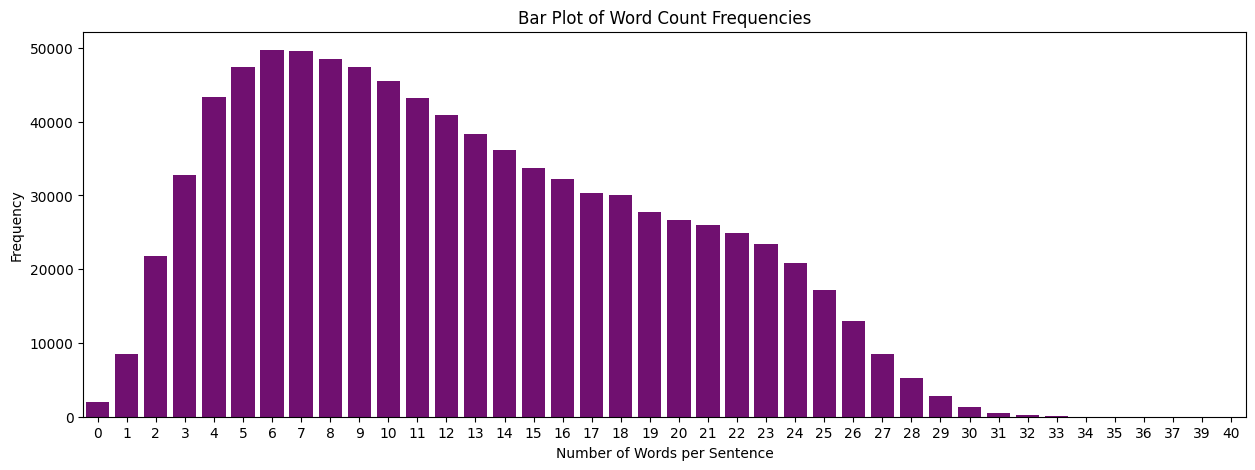

In [ ]:
df['word_count'] = df['preprocessing_sentence'].apply(lambda x: len(str(x).split()))

word_count_freq = df['word_count'].value_counts().sort_index()
plt.figure(figsize=(15, 5))
sns.barplot(x=word_count_freq.index, y=word_count_freq.values, color='purple')
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.title("Bar Plot of Word Count Frequencies")
plt.show()

In [ ]:
# Filter out sentences with fewer than 5 words
df = df[df['word_count'] >= 5].reset_index(drop=True)
df.head()

,label,sentence,preprocessing_sentence,word_count
0,1,http://twitpic.com/6hozr - This is the pic tha...,this is the pic that is on mollies phone that ...,14
1,1,repeating you. you. you. you. you.,repeating you you you you you,6
2,1,@domrout Hooray! Thank you very much! Your per...,hooray thank you very much your performance li...,12
3,1,@106andpark I wanna see Eminem and Brittany Sp...,i wanna see eminem and brittany spears im a go...,21
4,0,"so, after all that fuss #digitalbritain is jus...",so after all that fuss digitalbritain is just ...,18


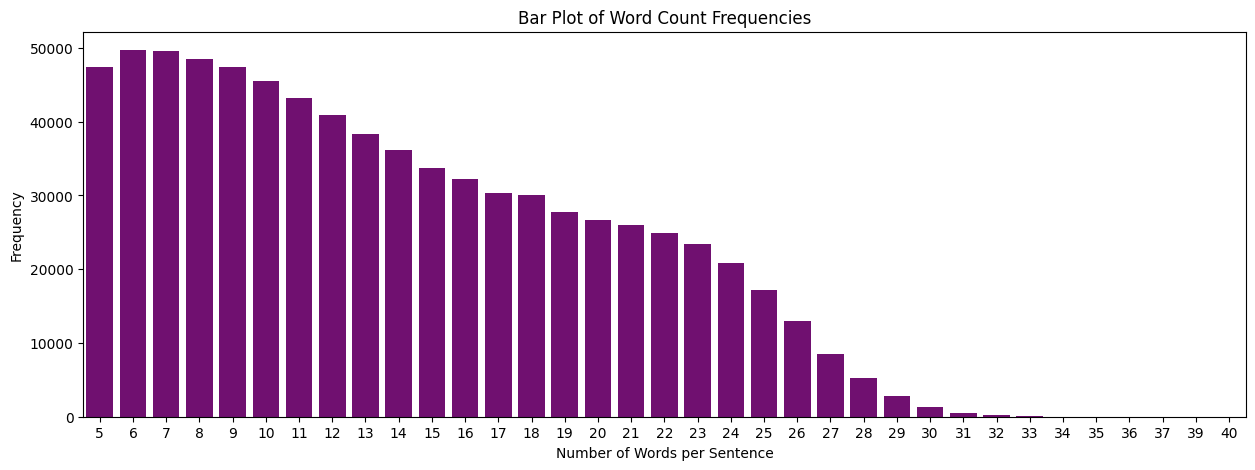

In [ ]:
df['word_count'] = df['preprocessing_sentence'].apply(lambda x: len(str(x).split()))
word_count_freq = df['word_count'].value_counts().sort_index()

plt.figure(figsize=(15, 5))
sns.barplot(x=word_count_freq.index, y=word_count_freq.values, color='purple')
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.title("Bar Plot of Word Count Frequencies")
plt.show()

In [ ]:
df_label_0 = df[df['label'] == 0]  
df_label_1 = df[df['label'] == 1]  

sample_size = 370000
df_label_0_sampled = df_label_0.sample(n=sample_size, random_state=42)  
df_label_1_sampled = df_label_1.sample(n=sample_size, random_state=42)  

df = pd.concat([df_label_0_sampled, df_label_1_sampled])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df['label'].value_counts()) 

print("Number of unique values:", df['label'].nunique())
print("Unique values:", df['label'].unique())
print("Value Counts:", df['label'].value_counts() )

Number of unique values: 2
Unique values: [1 0]
Value Counts: label
1    370000
0    370000
Name: count, dtype: int64


In [13]:
sentences = df.preprocessing_sentence.values
labels = df.label.values

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  just woke up yawn so warm todayi can wear shorts
Tokenized:  ['just', 'woke', 'up', 'ya', '##wn', 'so', 'warm', 'today', '##i', 'can', 'wear', 'shorts']
Token IDs:  [2074, 8271, 2039, 8038, 7962, 2061, 4010, 2651, 2072, 2064, 4929, 9132]


In [ ]:
input_ids = []
attention_masks = []

for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# lists of input_ids and attention_masks are concatenated into PyTorch tensors using torch.cat
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0) # dim=0 ensures that the tensors are concatenated along the batch dimension.
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  just woke up yawn so warm todayi can wear shorts
Token IDs: tensor([ 101, 2074, 8271, 2039, 8038, 7962, 2061, 4010, 2651, 2072, 2064, 4929,
        9132,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset)) 
val_size = int(0.07 * len(dataset))    
test_size = len(dataset) - train_size - val_size  
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'{train_size:,} training samples')
print(f'{val_size:,} validation samples')
print(f'{test_size:,} test samples')

666,000 training samples
51,800 validation samples
22,200 test samples


### **What is bert-base-uncased ?**

**1- BERT Variant: This is the base version of BERT with 12 layers, 768 hidden units, and 110 million parameters.**

**2- Uncased: The model is case-insensitive, meaning it treats uppercase and lowercase letters as the same (e.g., "Hello" and "hello" are treated identically).**

### **Why choose bert-base-uncased ?**

**Efficiency: Smaller than bert-large (24 layers, 1024 hidden units), making it faster and more memory-efficient.**

**Generalization: Works well for most NLP tasks, including sentiment analysis.**

**Pre-trained on Lowercase Text: Ideal for tasks where case sensitivity is not important (e.g., sentiment analysis of social media text).**

In [ ]:
batch_size = 128


train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size )


validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size )

test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset), 
    batch_size=batch_size )

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False,)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 ) # eps=1e-8 A small value to prevent division by zero in the optimizer.

epochs = 3
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler to Adjust the learning rate during training to improve convergence and avoid overshooting the optimal solution.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten() # Flattens the predictions and labels into 1D arrays.
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train_epoch(model, train_dataloader, optimizer, scheduler, device):

    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()

        # forward pass
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        #  backward pass 
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        #  Print the loss every 1000 batches.
        if (step + 1) % 1000 == 0:
            print(f"Batch {step + 1}/{len(train_dataloader)}: Loss = {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_dataloader)

    return avg_train_loss

def validate_epoch(model, validation_dataloader, device):
    
    # Set Model to Evaluation Mode
    model.eval() 

    total_eval_accuracy = 0
    total_eval_loss = 0


    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Perform a forward pass without computing gradients
        with torch.no_grad():
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    return avg_val_loss, avg_val_accuracy


def save_best_model(model, output_dir, best_val_loss, avg_val_loss):

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        print(f"  New best validation loss: {best_val_loss:.2f}. Saving model...")
        # Save the model and tokenizer
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir) 
    return best_val_loss

## Model Training

In [ ]:
def train_model(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs, device, output_dir):
    training_stats = []
    best_val_loss = float('inf')  # Initialize the best validation loss to infinity

    for epoch_i in range(epochs):
        print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
        print("Training...")

        avg_train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
        print(f"\n  Average training loss: {avg_train_loss:.2f}")

        print("\nRunning Validation...")
        avg_val_loss, avg_val_accuracy = validate_epoch(model, validation_dataloader, device)
        print(f"  Accuracy: {avg_val_accuracy:.2f}")
        print(f"  Validation Loss: {avg_val_loss:.2f}")

        # Record statistics for this epoch
        training_stats.append({
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
        })


        best_val_loss = save_best_model(model, output_dir, best_val_loss, avg_val_loss)

    print("\nTraining complete!")
    return training_stats

In [27]:
output_dir = '/kaggle/working/best_model_save/'
training_stats = train_model(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs, device, output_dir)


======== Epoch 1 / 3 ========
Training...
Batch 1000/5204: Loss = 0.4466
Batch 2000/5204: Loss = 0.3423
Batch 3000/5204: Loss = 0.4227
Batch 4000/5204: Loss = 0.3350
Batch 5000/5204: Loss = 0.3196

  Average training loss: 0.37

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.34
  New best validation loss: 0.34. Saving model...

======== Epoch 2 / 3 ========
Training...
Batch 1000/5204: Loss = 0.2247
Batch 2000/5204: Loss = 0.1992
Batch 3000/5204: Loss = 0.3517
Batch 4000/5204: Loss = 0.3596
Batch 5000/5204: Loss = 0.3253

  Average training loss: 0.30

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.34
  New best validation loss: 0.34. Saving model...

======== Epoch 3 / 3 ========
Training...
Batch 1000/5204: Loss = 0.2705
Batch 2000/5204: Loss = 0.1634
Batch 3000/5204: Loss = 0.3093
Batch 4000/5204: Loss = 0.3055
Batch 5000/5204: Loss = 0.2414

  Average training loss: 0.26

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.36

Training complete!


## Evaluate on the test set


In [ ]:
def predict_and_evaluate(model, test_dataloader, device):

    model.eval()

    total_test_loss = 0
    total_test_accuracy = 0
    predictions = []
    true_labels = []


    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)


            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

            loss = outputs.loss
            logits = outputs.logits

            total_test_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()


            total_test_accuracy += flat_accuracy(logits, label_ids)


            pred_flat = np.argmax(logits, axis=1).flatten()
            predictions.extend(pred_flat)
            true_labels.extend(label_ids.flatten())

    # Calculate average loss and accuracy
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_accuracy = total_test_accuracy / len(test_dataloader)

    return predictions, true_labels, avg_test_loss, avg_test_accuracy

## Load Best Model 

In [ ]:
my_model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)
my_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Evaluate on the test set
predictions, true_labels, test_loss, test_accuracy = predict_and_evaluate(my_model, test_dataloader, device)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

Test Accuracy: 0.86
Test Loss: 0.33


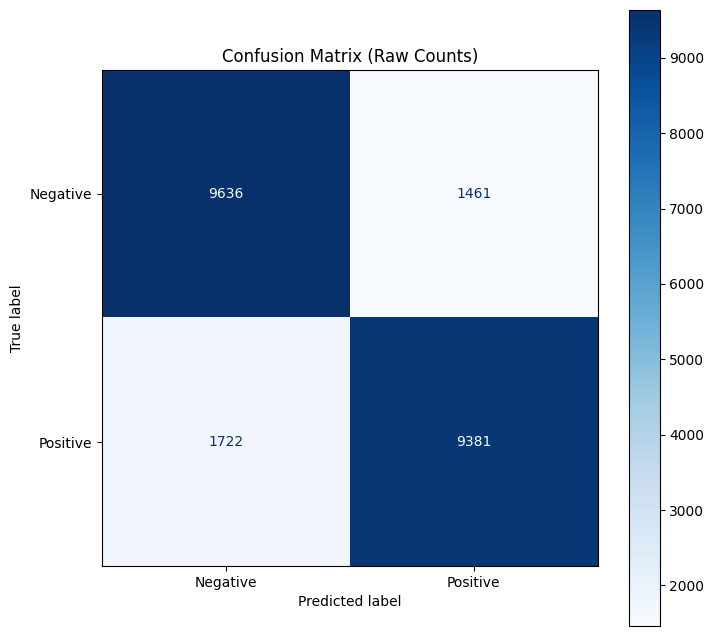

Classification Report:

              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86     11097
    Positive       0.87      0.84      0.85     11103

    accuracy                           0.86     22200
   macro avg       0.86      0.86      0.86     22200
weighted avg       0.86      0.86      0.86     22200



In [ ]:
def plot_confusion_matrix(predictions, true_labels, class_names):

    cm = confusion_matrix(true_labels, predictions)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap='Blues', ax=ax, values_format='d')  # 'd' for displaying raw counts
    plt.title("Confusion Matrix (Raw Counts)")
    plt.show()

    report = classification_report(true_labels, predictions, target_names=class_names)
    print("Classification Report:\n")
    print(report)

class_names = ['Negative', 'Positive']  

plot_confusion_matrix(predictions, true_labels, class_names)


In [ ]:

def process_and_predict_sentence(sentence, model, tokenizer, device='cuda'):

    encoded_dict = tokenizer.encode_plus(
        sentence,                     
        add_special_tokens=True,     
        max_length=64,                
        pad_to_max_length=True,      
        truncation=True,              
        return_attention_mask=True,   
        return_tensors='pt'           
    )


    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    model.eval()

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)

    return probabilities


## Test The Model

In [ ]:
test_sentence = "The movie was fantastic!"
prob = process_and_predict_sentence(test_sentence, model, tokenizer)
prob

tensor([[0.0023, 0.9977]], device='cuda:0')

In [ ]:
def process_and_predict_sentences(sentences, model, tokenizer):
    # Tokenize all sentences in the list
    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Convert probabilities to a list of lists
    probs = probs.cpu().numpy().tolist()  # Move to CPU and convert to list

    # Determine the label for each sentence based on the highest probability
    results = []
    for i, sentence in enumerate(sentences):
        label = "negative" if probs[i][0] > probs[i][1] else "positive"
        results.append({"Sentence": sentence, "label": label})

    return results

test_sentences = [
    "I hate the selfishness in you",
    "The movie was fantastic!"]


results = process_and_predict_sentences(test_sentences, model, tokenizer)

for result in results:
    print(result)

{'Sentence': 'I hate the selfishness in you', 'label': 'negative'}
{'Sentence': 'The movie was fantastic!', 'label': 'positive'}
